In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import numba as nb

In [2]:
@jit(nopython=True)
def LV_compute(S, D, A, T, step):

    N_mean = 1 / (S * A * np.sqrt(np.pi / 2))
    NN = np.zeros((T, S))
    r = np.ones(S)
    AA = np.random.rand(S, S) * A * 2
    AA = AA - np.diag(np.diag(AA)) + np.eye(S)  # 对角线元素设为 1
    N0 = np.ones(S)*N_mean
    NN[0] = N0
    Migra = np.ones(S) * D
    
    for i in range(1, T):
        
        k1 = r * NN[i-1] * (1- np.dot(AA, NN[i-1]))* step
        k2 = r * (NN[i-1]+k1/2) * (1- np.dot(AA, NN[i-1]+k1/2))*step
        k3 = r * (NN[i-1]+k2/2) * (1- np.dot(AA, NN[i-1]+k2/2))*step
        k4 = r * (NN[i-1]+k3) * (1- np.dot(AA, NN[i-1]+k3))*step
        #NN[i] = NN[i-1] + r * NN[i-1] * (1- np.dot(AA, NN[i-1])) * step
        NN[i] = NN[i-1]+ (k1+2*k2+2*k3+k4)/6
        NN[i] += Migra  # 添加迁移
        
    return NN

In [3]:
# 参数定义
r_mean = 1.0  # 平均增长率
#S = np.arange(10, 40, 10)
S = np.arange(13, 43, 3)
DD = 1e-6  # 迁移率
A_mean_range = [0.01, 1.0]  # 平均抑制系数范围
ystep = 20  # A_mean 的步数
T_real = 1000  # 总进化时间
step = 0.05  # 时间间隔
T = int(np.ceil(T_real / step))  # 循环次数
num_sim = 100  # 系综平均次数
period = 200  # 用于计算丰富度的持续时间
abundance_threshold = 1e-3  # 物种生存的丰度阈值

# 初始化记录矩阵
fluc_record = np.zeros((len(S) , ystep, num_sim))
diversity_record = np.zeros((len(S) , ystep, num_sim))
fluc_mean = np.zeros((len(S) , ystep))
div_mean = np.zeros((len(S) , ystep))

A_mean = np.linspace(A_mean_range[0], A_mean_range[1], ystep)

In [4]:
@jit(nopython=True)
def axis_of_cols(matrix, num_cols):
    maxc = np.zeros(num_cols)
    flucc= np.zeros(num_cols)
    matrix_2 = matrix.T
    richness =0
    
    for i in range(num_cols):       
        maxc[i] =  np.max(matrix_2[i][500-period:500])
        if maxc[i]> abundance_threshold:
            richness+=1
            mean_v = np.mean(matrix_2[i])
            if mean_v!=0 and not np.isnan(np.std(matrix_2[i]) /mean_v):
                flucc[i] = np.std(matrix_2[i]) /mean_v

    return  richness, flucc

In [5]:
for mm in range(len(S)):
    print("S=",S[mm])
    for pp in range(ystep):
        for hh in range(num_sim):
            # 调用 LV_compute 函数来计算组成
            composition = LV_compute(S[mm], DD, A_mean[pp], T, step)
            richness,fluc_CV = axis_of_cols(composition[T - 500:T], S[mm])
            diversity_record[mm , pp, hh] = richness / S[mm]
            fluc_record[mm, pp, hh] = np.sum(fluc_CV)/ richness
        div_mean[mm,pp] = np.mean(diversity_record[mm,pp])
        fluc_mean[mm,pp]= np.sum(fluc_record[mm , pp]*diversity_record[mm,pp])/np.sum(diversity_record[mm,pp])

S= 13
S= 16
S= 19
S= 22
S= 25
S= 28
S= 31
S= 34
S= 37
S= 40


In [6]:
np.save('div_mean_best.npy',div_mean)
np.save('fluc_mean_best.npy',fluc_mean)

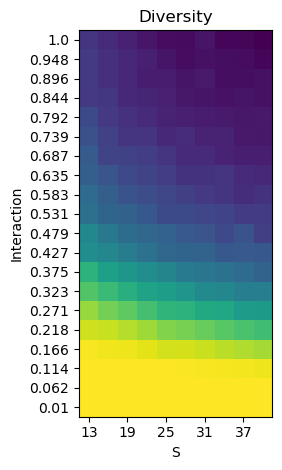

In [10]:
A_mean_2 = A_mean
A_mean_2 = np.around(A_mean_2,3)
plt.imshow(div_mean.T,origin='lower')
plt.xticks(np.arange(0,10,2),S[::2])
plt.yticks(np.arange(0,ystep,1),A_mean_2)
plt.xlabel("S")  # 设置横轴标签
plt.ylabel("Interaction")  # 设置纵轴标签
plt.title("Diversity")   # 设置标题（可选）
plt.tight_layout()
plt.show()

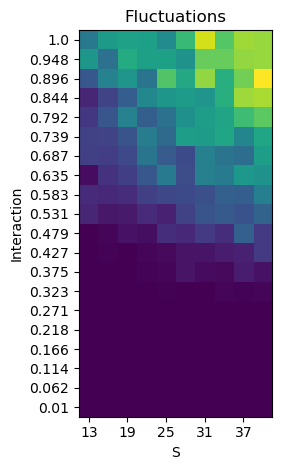

In [11]:
plt.imshow(fluc_mean.T, origin='lower')
plt.xticks(np.arange(0,10,2),S[::2])
plt.yticks(np.arange(0,ystep,1),A_mean_2)
plt.xlabel("S")  # 设置横轴标签
plt.ylabel("Interaction")  # 设置纵轴标签
plt.title("Fluctuations")   # 设置标题（可选）
plt.tight_layout()
plt.show()

In [9]:
#plt.plot(range(20),fluc_mean_1d)
#plt.plot(range(20),div_mean_1d)

In [10]:
# 初始化记录矩阵
num_sim = 100

fluc_record_1d = np.zeros(( ystep, num_sim))
diversity_record_1d = np.zeros(( ystep, num_sim))
fluc_mean_1d = np.zeros(( ystep))
fluc_mean_1d_2 = np.zeros(( ystep))
div_mean_1d = np.zeros(( ystep))

for pp in range(ystep):
    for hh in range(num_sim):
        # 调用 LV_compute 函数来计算组成
        composition = LV_compute(40, DD, A_mean[pp], T, step)
            
        # 计算多样性指数
        # 计算稳态下各个种群的最大密度
        diversity_index = np.max(composition[T - period:T], axis=0)
        richness = np.where(diversity_index > abundance_threshold)[0]
        diversity_record_1d[pp, hh] = len(richness) / 40
            
        # 计算波动系数
        fluc_CV = np.std(composition[T - 500:T], axis=0) / np.mean(composition[T - 500:T], axis=0)
        count = np.isnan(fluc_CV).sum()
        fluc_CV = np.nan_to_num(fluc_CV)  # 将 NaN 值替换为 0
        
        fluc_record_1d[ pp, hh] = np.sum(fluc_CV)/(len(fluc_CV)-count)
        
        
    div_mean_1d[pp] = np.mean(diversity_record_1d[pp])
    fluc_mean_1d[pp]= np.mean(fluc_record_1d[pp])

In [11]:

for pp in range(ystep):
    fluc_mean_1d_2[pp] = np.sum(fluc_record_1d[pp]*diversity_record_1d[pp])/np.sum(diversity_record_1d[pp])

In [ ]:
#plt.plot(A_mean,fluc_mean_1d)
plt.plot(A_mean,div_mean_1d)
plt.plot(A_mean,fluc_mean_1d_2)

In [ ]:
num_s = 50
x_zhou = np.arange(T)
composition = LV_compute(num_s, DD, 0.7, T, step)
for i in range(num_s):
    plt.plot(np.log(x_zhou+1)*0.43,np.log(composition.T[i])*0.43)